Model Training Complete! Generating Feature Importance...


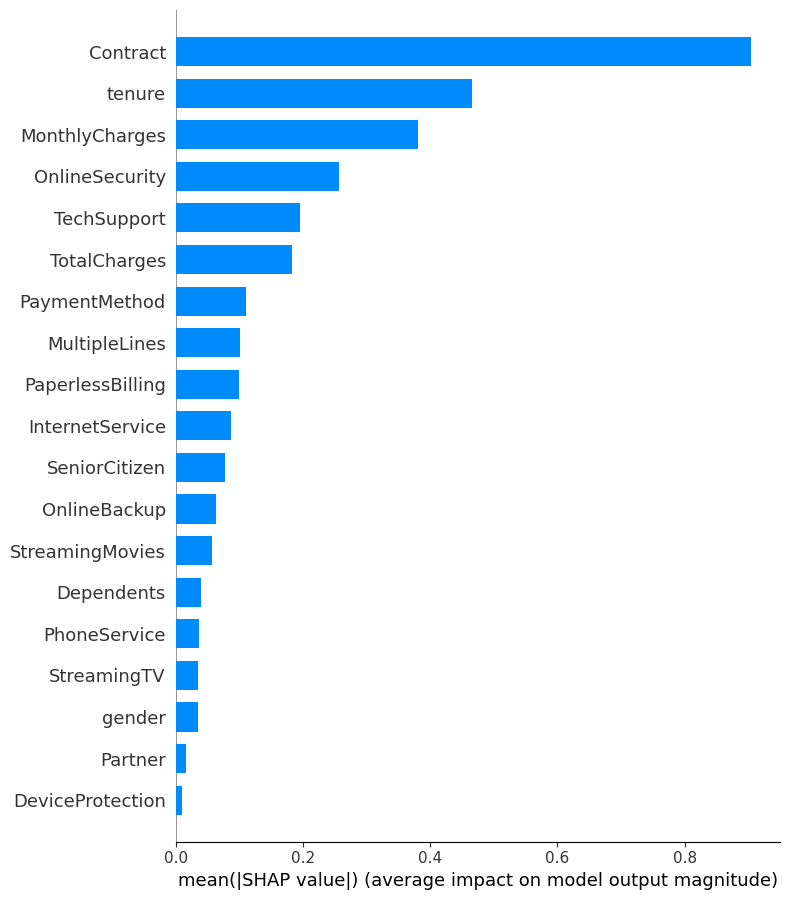

In [4]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Load Data
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# 2. Data Cleaning for Product Use
# Convert TotalCharges to numeric and drop rows with missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
customer_ids = df['customerID'] # Save for later
df.drop(['customerID'], axis=1, inplace=True)

# 3. Encoding (Converting text to numbers for the AI)
le = LabelEncoder()
mappings = {}
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])
    mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# 4. Split Data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train the Model
model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

# 6. Generate the Product Insight (SHAP)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

print("Model Training Complete! Generating Feature Importance...")

# Visualize which features drive churn globally
shap.summary_plot(shap_values, X_test, plot_type="bar")

--- Customer Retention Report ---
Customer ID: 1174-FGIFN
Churn Risk Score: 0.87%
Status: Low risk. Maintain standard engagement.


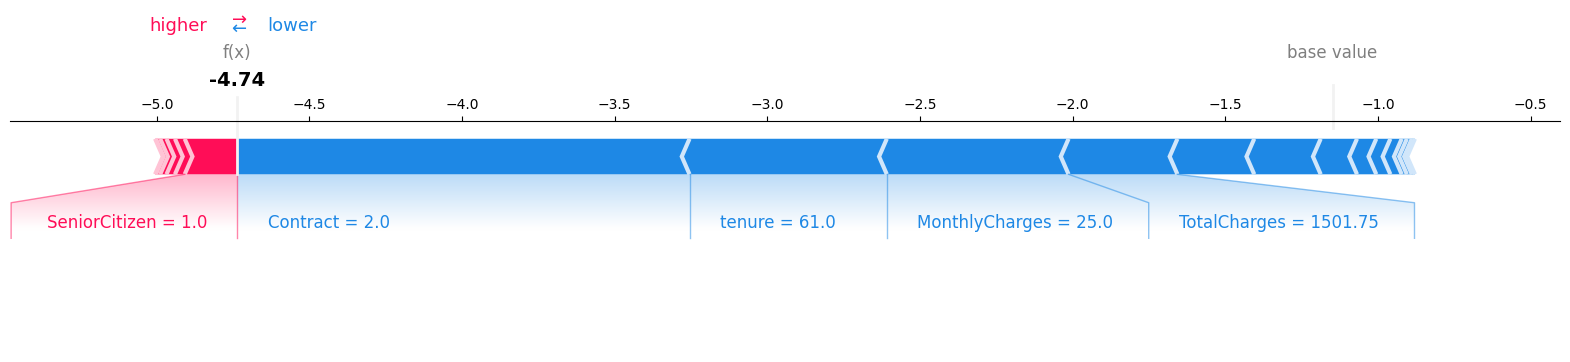

In [3]:
# Pick a specific customer from the test set (e.g., the first one)
sample_idx = 0 
individual_prediction = model.predict_proba(X_test.iloc[[sample_idx]])[0][1]
customer_real_id = customer_ids.iloc[X_test.index[sample_idx]]

print(f"--- Customer Retention Report ---")
print(f"Customer ID: {customer_real_id}")
print(f"Churn Risk Score: {individual_prediction:.2%}")

if individual_prediction > 0.5:
    print("Action Required: This customer is likely to leave. Send a retention offer!")
else:
    print("Status: Low risk. Maintain standard engagement.")

# Explain this specific customer's score
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_test.iloc[sample_idx], matplotlib=True)

In [7]:
import pickle

# Save the model
with open('churn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the mappings (we need these to turn "Month-to-month" back into 0 or 1)
with open('mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)

print("Model and Mappings exported successfully!")

Model and Mappings exported successfully!
